# Your First Elastic Agent

This notebook is the API-driven companion to the blog post, **"Your First Elastic Agent: From a Single Query to an AI-Powered Chat."**

Here, we'll perform every step from the article—creating a tool, building an agent, and having a conversation—using Python to interact directly with the Agent Builder APIs.

### Prerequisites

To run this notebook, you will need:
* An active Elastic Cloud Serverless Project.
  * You can sign up for a free trial at [Elastic Cloud Trial Page](https://cloud.elastic.co/trial)
  * Create an `Elasticsearch` type project
* The URLs for both Elasticsearch and Kibana
  * [How to get ES URL](https://www.elastic.co/docs/solutions/search/search-connection-details#find-cloud-id-serverless)
  * For kibana, replace `.es.` in the url with `.kb.` in the ES URL
* An API Key with `write` permissions for Elasticsearch and Kibana (same API Key.
  * [Doc page showing how to create API Key](https://www.elastic.co/docs/deploy-manage/api-keys/serverless-project-api-keys)

In [ ]:
import os

# Elasticsearch URL
es_url = input("Enter your Elasticsearch Endpoint URL: ")
# Kibana URL
kb_url = es_url.replace(".es.", ".kb.")
# Elastic API Key
es_api_key = input("Enter your Elasticsearch API Key: ")

print("Using connection details:")
print(f"Elasticsearch URL: {es_url}")
print(f"Kibana URL: {kb_url}")
print(f"ES_API_KEY: ***************************{es_api_key[-5:]}")

Using connection details:
Elasticsearch URL: https://your-first-elastic-agent-a4dc2b.es.us-central1.gcp.elastic.cloud:443
Kibana URL: https://your-first-elastic-agent-a4dc2b.kb.us-central1.gcp.elastic.cloud:443
ES_API_KEY: ***************************vZw==


## Load Financial Data
This section will load synthetic financial data into your Elastic project for use demoing:
- Tool creation
- Agent creation
- Using the agent with the converse api

If you have previously loaded the data you can skip this part.

If you want to use other data, you will have to adjust the ES|QL queries to match the fields you have, as well as adjust the agent prompt and conversation questions to match your data


In [ ]:
# Clone the repo
!git clone https://github.com/jeffvestal/synthetic-financial-data
%cd synthetic-financial-data

Cloning into 'synthetic-financial-data'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 368 (delta 27), reused 72 (delta 20), pack-reused 273 (from 1)
Receiving objects: 100% (368/368), 19.93 MiB | 13.48 MiB/s, done.
Resolving deltas: 100% (199/199), done.
/content/synthetic-financial-data


In [ ]:
# Install the python requirements to run the data loading script
!pip3 install -qr requirements.txt
!pip3 install -qr pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 937.5/937.5 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
# Wait until `.elser-2-elasticsearch` embedding inference endpoint is deployed and ready
import time, requests, os

# Define request details
headers = {"Authorization": f"ApiKey {es_api_key}", "Content-Type": "application/json"}
url = f"{es_url}/_inference/sparse_embedding/.elser-2-elasticsearch"
attempt = 0

# --- Main Check Loop ---
while True:
    attempt += 1
    print(f"Polling endpoint... (Attempt #{attempt})")

    try:
        # Attempt to connect and raise an exception on failure
        requests.post(
            url, headers=headers, json={"input": "test"}, timeout=15
        ).raise_for_status()
        print(f"✅ Endpoint is ready.")
        break  # <-- Exit the loop on success

    except requests.exceptions.RequestException as e:
        status = (
            e.response.status_code if e.response is not None else "N/A"
        )  # Modified line
        if e.response is not None and 400 <= status < 500:  # Modified line
            # Exit immediately on client errors (e.g., 404 Not Found, 401 Unauthorized)
            exit(
                f"❌ Client error ({status}). This is likely a permanent issue. Halting."
            )

        # On any other error (e.g., 503 Service Unavailable), wait and retry
        time.sleep(10)

Polling endpoint... (Attempt #1)
✅ Endpoint is ready.


In [ ]:
# Load existing data to Elasticsearch. Set timestamps to now

os.environ["ES_ENDPOINT_URL"] = es_url
os.environ["ES_API_KEY"] = es_api_key
!python3 load_all_data.py


🚀 FAST DATA LOADER - ALL INDICES
Settings: 1000 batch, 24 workers, timestamps→now
Time: 2025-09-23 04:29:02

/usr/local/lib/python3.12/dist-packages/elasticsearch/_sync/client/__init__.py:311: SecurityWarning: Connecting to 'https://your-first-elastic-agent-a4dc2b.es.us-central1.gcp.elastic.cloud:443' using TLS with verify_certs=False is insecure
  _transport = transport_class(
Elasticsearch client initialized successfully.
✓ Connected to Elasticsearch

  📁 Accounts: 7,000 documents
  📁 Holdings: 122,923 documents
  📁 Assets: 183 documents
  📁 News: 550 documents
  📁 Reports: 120 documents

📊 Total: 130,776 documents across 5 indices

⏳ Loading Accounts...Starting: financial_accounts (workers: 24, updating timestamps to current time)
Starting: financial_accounts (workers: 24, updating timestamps to current time)
Creating index 'financial_accounts'...
✓ Successfully created index 'financial_accounts'
  Updating timestamps to: 2025-09-23T04:29:03
[04:29:05] financial_accounts: batch 1/7

In [ ]:
# Check incices are setup and data was loaded
!python3 control.py --check-indices

🚀 Running in non-interactive mode...
🔍 Connecting to Elasticsearch...
/usr/local/lib/python3.12/dist-packages/elasticsearch/_sync/client/__init__.py:311: SecurityWarning: Connecting to 'https://your-first-elastic-agent-a4dc2b.es.us-central1.gcp.elastic.cloud:443' using TLS with verify_certs=False is insecure
  _transport = transport_class(
Elasticsearch client initialized successfully.
✅ Connected to Elasticsearch 8.11.0

                            📊 Index Status Summary                             
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Index Name            ┃ Exi… ┃ Docum… ┃   Size ┃ Errors                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ financial_asset_deta… │ ✓    │    183 │    N/A │                             │
│ financial_accounts    │ ✓    │  7,000 │    N/A │                             │
│ financial_holdings    │ ✓    │ 122,9… │    N/A │                             │
│ financ

## Kibana Setup for Agent Builder

In [ ]:
# Import necessary libraries
import os
import json
import requests
from getpass import getpass  # To securely ask for the API key
from IPython.display import display, Markdown, JSON

# --- Setup Headers ---
HEADERS = {
    "Content-Type": "application/json",
    "kbn-xsrf": "true",
    "Authorization": f"ApiKey {es_api_key}",
}

# --- Verify Connection ---
# Let's make a simple call to the root endpoint to verify our connection and credentials.
if not kb_url:
    print("⚠️ KIBANA_ENDPOINT was not provided. Please provide the endpoint URL.")
else:
    try:
        response = requests.get(kb_url + "/api/status", headers=HEADERS)
        response.raise_for_status()  # Raises an exception for bad status codes (4xx or 5xx)

        status = response.json()
        cluster_name = status.get("name")
        version = status.get("version").get("number")

        print(f"✅ Successfully connected to Kibana!")
        print(f"Cluster Name: {cluster_name}")
        print(f"Version: {version}")

    except requests.exceptions.RequestException as e:
        print(f"❌ Connection Failed: {e}")

✅ Successfully connected to Kibana!
Cluster Name: kb
Version: 9.2.0


#ONLY BEFORE PUBLIC PREVIEW:
You will need to enable Agent Builder in your project.

Do to this
1. Navigate to `Developer Tools` in Kibana
2. Run the following command
    ```
    POST kbn://internal/kibana/settings
    {
      "changes": {
          "agentBuilder:enabled": true
      }
    }
    ```
3. Refresh your browser

You should now see `Agents` in the navigation side bar


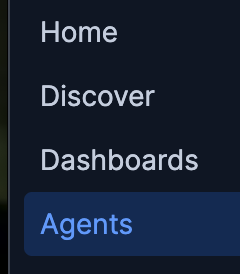


# Section 1: The Logic - Testing the ES|QL Query

Before we register our logic as a persistent Tool, it's a best practice to test the raw ES|QL query first. This allows us to validate the syntax and confirm it returns the data we expect. We'll use the `/_query` endpoint for this.

In [ ]:
# First, let's define our multi-line ES|QL query in a Python string.
# This is the same query that will eventually power our custom tool.

esql_query = """
FROM financial_news, financial_reports METADATA _index
  | WHERE sentiment == "negative"
  | WHERE coalesce(published_date, report_date) >= NOW() - TO_TIMEDURATION(?time_duration)
  | RENAME primary_symbol AS symbol
  | LOOKUP JOIN financial_asset_details ON symbol
  | LOOKUP JOIN financial_holdings ON symbol
  | LOOKUP JOIN financial_accounts ON account_id
  | WHERE account_holder_name IS NOT NULL
  | EVAL position_current_value = quantity * current_price.price
  | RENAME title AS news_title
  | KEEP
      account_holder_name, symbol, asset_name, news_title,
      sentiment, position_current_value, quantity, current_price.price,
      published_date, report_date
  | SORT position_current_value DESC
  | LIMIT 50
"""

print("✅ ES|QL query string is defined.")

✅ ES|QL query string is defined.


In [ ]:
# Now, we'll construct the JSON body for the API request.
# The `params` object is where we provide values for the placeholders in our query string.

request_body = {"query": esql_query, "params": [{"time_duration": "2000 hours"}]}

print("✅ Request body is defined with test parameters:")
print(json.dumps(request_body, indent=2))

✅ Request body is defined with test parameters:
{
  "query": "\nFROM financial_news, financial_reports METADATA _index\n  | WHERE sentiment == \"negative\"\n  | WHERE coalesce(published_date, report_date) >= NOW() - TO_TIMEDURATION(?time_duration)\n  | RENAME primary_symbol AS symbol\n  | LOOKUP JOIN financial_asset_details ON symbol\n  | LOOKUP JOIN financial_holdings ON symbol\n  | LOOKUP JOIN financial_accounts ON account_id\n  | WHERE account_holder_name IS NOT NULL\n  | EVAL position_current_value = quantity * current_price.price\n  | RENAME title AS news_title\n  | KEEP\n      account_holder_name, symbol, asset_name, news_title,\n      sentiment, position_current_value, quantity, current_price.price,\n      published_date, report_date\n  | SORT position_current_value DESC\n  | LIMIT 50\n",
  "params": [
    {
      "time_duration": "2000 hours"
    }
  ]
}


In [ ]:
# Finally, let's execute the query and display the results in a clean table using pandas.
import pandas as pd

# display(Markdown(f"### 🧪 Testing Query for Symbol: `{request_body['params'][1]['symbol']}`"))

try:
    # We use the /_query endpoint to run a raw ES|QL query
    response = requests.post(f"{es_url}/_query", headers=HEADERS, json=request_body)
    response.raise_for_status()

    # The response contains column names and rows of values
    query_result = response.json()
    columns = [col["name"] for col in query_result["columns"]]
    # Check for 'values' key if 'rows' is not present
    rows = query_result.get("rows", query_result.get("values", []))

    # Create and display a pandas DataFrame for a clean table view
    df = pd.DataFrame(rows, columns=columns)
    display(df)

except requests.exceptions.RequestException as e:
    print(f"❌ Query Failed: {e.response.text}")
except KeyError:
    print("❌ Query executed, but the response format was unexpected.")
    print("Raw response:")
    print(response.json())
    raise

,account_holder_name,symbol,asset_name,news_title,sentiment,position_current_value,quantity,current_price.price,published_date,report_date
0,Victoria Schneider,TXN,Texas Instruments Inc.,"TXN Tumbles on Major Cybersecurity Breach, IP ...",negative,273680.004883,200.0,1368.400024,2025-09-23T04:29:29.000Z,None
1,Lorraine Gibson,TXN,Texas Instruments Inc.,"TXN Tumbles on Major Cybersecurity Breach, IP ...",negative,272311.604858,199.0,1368.400024,2025-09-23T04:29:29.000Z,None
2,Jillian Davis,TXN,Texas Instruments Inc.,"TXN Tumbles on Major Cybersecurity Breach, IP ...",negative,272311.604858,199.0,1368.400024,2025-09-23T04:29:29.000Z,None
3,Craig Griffith,TXN,Texas Instruments Inc.,"TXN Tumbles on Major Cybersecurity Breach, IP ...",negative,272311.604858,199.0,1368.400024,2025-09-23T04:29:29.000Z,None
4,Jeffrey Byrd,TXN,Texas Instruments Inc.,"TXN Tumbles on Major Cybersecurity Breach, IP ...",negative,270943.204834,198.0,1368.400024,2025-09-23T04:29:29.000Z,None
5,Patrick Rice,TXN,Texas Instruments Inc.,"TXN Tumbles on Major Cybersecurity Breach, IP ...",negative,270943.204834,198.0,1368.400024,2025-09-23T04:29:29.000Z,None
6,Sophia Dean,TXN,Texas Instruments Inc.,"TXN Tumbles on Major Cybersecurity Breach, IP ...",negative,270943.204834,198.0,1368.400024,2025-09-23T04:29:29.000Z,None
7,Sandra Nunez,TXN,Texas Instruments Inc.,"TXN Tumbles on Major Cybersecurity Breach, IP ...",negative,269574.804810,197.0,1368.400024,2025-09-23T04:29:29.000Z,None
8,Brandon Esparza,TXN,Texas Instruments Inc.,"TXN Tumbles on Major Cybersecurity Breach, IP ...",negative,269574.804810,197.0,1368.400024,2025-09-23T04:29:29.000Z,None
9,Miranda Vargas,TXN,Texas Instruments Inc.,"TXN Tumbles on Major Cybersecurity Breach, IP ...",negative,269574.804810,197.0,1368.400024,2025-09-23T04:29:29.000Z,None


# Section 2: The Skill - Creating the Custom Tool

Now that we've validated our query, it's time to register it as a persistent **Tool**. This makes our logic available to any AI agent.

The most important parts of this definition are the `description` fields. The main `description` tells the agent *what the tool does*, and the parameter descriptions explain *what kind of information the tool needs* to run. The LLM uses this text to decide when and how to use our tool.

In [ ]:
# First, let's define the full JSON payload for our new tool.
# This includes its ID, a description for the LLM, the ES|QL query, and the parameter schema.

tool_id = "find_client_exposure_to_negative_news"

tool_definition = {
    "id": tool_id,
    "type": "esql",
    "description": "Finds client portfolio exposure to negative news. This tool scans recent news and reports for negative sentiment, identifies the associated asset, and finds all clients holding that asset. It returns a list sorted by the current market value of the position to highlight the highest potential risk.",
    "configuration": {
        "query": """
        FROM financial_news, financial_reports METADATA _index
        | WHERE sentiment == "negative"
        | WHERE coalesce(published_date, report_date) >= NOW() - TO_TIMEDURATION(?time_duration)
        | RENAME primary_symbol AS symbol
        | LOOKUP JOIN financial_asset_details ON symbol
        | LOOKUP JOIN financial_holdings ON symbol
        | LOOKUP JOIN financial_accounts ON account_id
        | WHERE account_holder_name IS NOT NULL
        | EVAL position_current_value = quantity * current_price.price
        | RENAME title AS news_title
        | KEEP
            account_holder_name, symbol, asset_name, news_title,
            sentiment, position_current_value, quantity, current_price.price,
            published_date, report_date
        | SORT position_current_value DESC
        | LIMIT 50
      """,
        "params": {
            "time_duration": {
                "type": "keyword",
                "description": """The timeframe to search back for negative news. Format is "X hours" DEFAULT TO 8760 hours """,
            }
        },
    },
    "tags": ["retrieval", "risk-analysis"],
}


print(f"✅ Tool definition for '{tool_id}' is ready.")
# Displaying the JSON we are about to send
display(JSON(tool_definition))

✅ Tool definition for 'find_client_exposure_to_negative_news' is ready.


<IPython.core.display.JSON object>

In [ ]:
# Now, let's create the tool by sending a POST request to the /api/chat/tools endpoint.

display(Markdown(f"Create Tool: `{tool_id}`"))

try:
    # Note that Kibana API endpoints are prefixed with kbn:// but accessed via the standard HTTP endpoint
    response = requests.post(
        f"{kb_url}/api/agent_builder/tools", headers=HEADERS, json=tool_definition
    )
    response.raise_for_status()

    print(f"✅ Successfully created the tool!")
    # Display the server's response
    display(JSON(response.json()))

except requests.exceptions.RequestException as e:
    # Handle cases where the tool might already exist or other errors
    if (
        e.response.status_code == 400
        and "Tool with id" in e.response.text
        and "already exists" in e.response.text
    ):
        print(f"⚠️ Tool with ID '{tool_id}' already exists. Continuing.")
    else:
        print(f"❌ Tool creation failed: {e.response.text}")

Create Tool: `find_client_exposure_to_negative_news`

✅ Successfully created the tool!


<IPython.core.display.JSON object>

In [ ]:
# Finally, let's verify the tool was created by fetching it directly by its ID.

display(Markdown(f"### 🔍 Verifying Tool: `{tool_id}`"))

try:
    response = requests.get(
        f"{kb_url}/api/agent_builder/tools/{tool_id}", headers=HEADERS
    )
    response.raise_for_status()

    print("✅ Tool exists! Details below:")
    display(JSON(response.json()))

except requests.exceptions.RequestException as e:
    print(f"❌ Could not retrieve tool: {e.response.text}")

### 🔍 Verifying Tool: `find_client_exposure_to_negative_news`

✅ Tool exists! Details below:


<IPython.core.display.JSON object>

# Section 3: The Brains - Creating the Custom Agent

With our "skill" (the Tool) created, we now need to create the "brain" (the **Agent**). The Agent is the persona that combines the power of an LLM with a specific set of tools and, most importantly, a set of "Custom Instructions."

These instructions act as the agent's constitution. They define its personality, its mission, and the rules it must follow. A well-crafted prompt is the key to creating a reliable and specialized assistant.

In [ ]:
# First, let's define the detailed instructions for our "Financial Manager" agent.
# This prompt tells the agent who it is, what it should do, and what it absolutely should NOT do.

financial_assistant_prompt = """
You are a specialized Data Intelligence Assistant for financial managers, designed to provide precise, data-driven insights from information stored in Elasticsearch.

**Your Core Mission:**
- Respond accurately and concisely to natural language queries from financial managers.
- Provide precise, objective, and actionable information derived solely from the Elasticsearch data at your disposal.
- Summarize key data points and trends based on user requests.

**Reasoning Framework:**
1.  **Understand:** Deconstruct the user's query to understand their core intent.
2.  **Plan:** Formulate a step-by-step plan to answer the question. If you are unsure about the data structure, use the available tools to explore the indices first.
3.  **Execute:** Use the available tools to execute your plan.
4.  **Synthesize:** Combine the information from all tool calls into a single, comprehensive, and easy-to-read answer.

**Key Directives and Constraints:**
- **If a user's request is ambiguous, ask clarifying questions before proceeding.**
- **DO NOT provide financial advice, recommendations, or predictions.** Your role is strictly informational and analytical.
- Stay strictly on topic with financial data queries.
- If you cannot answer a query, state that clearly and offer alternative ways you might help *within your data scope*.
- All numerical values should be formatted appropriately (e.g., currency, percentages).

**Output Format:**
- All responses must be formatted using **Markdown** for clarity.
- When presenting structured data, use Markdown tables, lists, or bolding.

**Start by greeting the financial manager and offering assistance.**
"""

print("✅ Agent prompt is defined.")

✅ Agent prompt is defined.


In [ ]:
# Now, let's define the full agent payload.
# We'll give it an ID, a name, and a configuration that includes our prompt and access to our ES|QL tools.

agent_id = "financial_assistant"

agent_definition = {
    "id": agent_id,
    "name": "Financial Assistant",
    "description": "An assistant for analyzing and understanding your financial data",
    "labels": ["Finance"],
    "avatar_color": "#16C5C0",
    "avatar_symbol": "💰",
    "configuration": {
        "instructions": financial_assistant_prompt,
        "tools": [
            {
                "tool_ids": [
                    "platform.core.search",
                    "platform.core.list_indices",
                    "platform.core.get_index_mapping",
                    "platform.core.get_document_by_id",
                    "find_client_exposure_to_negative_news",
                ]
            }
        ],
    },
}

print(f"✅ Agent definition for '{agent_id}' is ready.")
display(JSON(agent_definition))

✅ Agent definition for 'financial_assistant' is ready.


<IPython.core.display.JSON object>

In [ ]:
# Create the agent by sending a POST request to the /api/chat/agents endpoint.

display(Markdown(f"### 🤖 Creating Agent: `{agent_id}`"))

try:
    response = requests.post(
        f"{kb_url}/api/agent_builder/agents", headers=HEADERS, json=agent_definition
    )
    response.raise_for_status()

    print(f"✅ Successfully created the agent!")
    display(JSON(response.json()))

except requests.exceptions.RequestException as e:
    if e.response.status_code == 409:
        print(f"⚠️ Agent with ID '{agent_id}' already exists. Continuing.")
    else:
        print(f"❌ Agent creation failed: {e.response.text}")

### 🤖 Creating Agent: `financial_assistant`

✅ Successfully created the agent!


<IPython.core.display.JSON object>

In [ ]:
# Finally, let's verify the agent was created by fetching it directly by its ID.

display(Markdown(f"### 🔍 Verifying Agent: `{agent_id}`"))

try:
    response = requests.get(
        f"{kb_url}/api/agent_builder/agents/{agent_id}", headers=HEADERS
    )
    response.raise_for_status()

    print("✅ Agent exists! Details below:")
    display(JSON(response.json()))

except requests.exceptions.RequestException as e:
    print(f"❌ Could not retrieve agent: {e.response.text}")

### 🔍 Verifying Agent: `financial_assistant`

✅ Agent exists! Details below:


<IPython.core.display.JSON object>

## Section 4: The Payoff! — Chatting with the Agent

Everything is now in place. We have our logic (the Tool) and our expert persona (the Agent). It's time to ask our `Financial Assistant` agent the complex, multi-step question from the blog post and see how it performs.

We'll send our question to the `/api/agent_builder/converse` endpoint, making sure to specify our agent's ID.

In [ ]:
# First, define the complex question we want to ask.
# user_question = "Who has the highest account value and what is their highest valued individual asset?"
user_question = "I'm worried about market sentiment. Can you show me which of our clients are most at risk from bad news?"

# Next, construct the request body for the /api/agent_builder/converse endpoint.
# It's crucial that we specify the `agent_id` so we talk to our custom agent.
chat_request_body = {
    "input": user_question,
    "agent_id": agent_id,  # Using the agent_id variable from the previous section
}


print(f"✅ Chat request for agent '{agent_id}' is ready.")
display(JSON(chat_request_body))

✅ Chat request for agent 'financial_assistant' is ready.


<IPython.core.display.JSON object>

In [ ]:
# Now, let's send the request and start the conversation!
# This single API call will trigger the agent's complex reasoning process.

display(Markdown(f"### 💬 Asking: '{user_question}'"))

chat_response = None  # Initialize variable to store the response

try:
    response = requests.post(
        f"{kb_url}/api/agent_builder/converse", headers=HEADERS, json=chat_request_body
    )
    response.raise_for_status()

    chat_response = response.json()
    print("✅ Agent responded successfully! See the analysis in the next cell.")

except requests.exceptions.RequestException as e:
    print(f"❌ Chat request failed: {e.response.text}")

### 💬 Asking: 'I'm worried about market sentiment. Can you show me which of our clients are most at risk from bad news?'

✅ Agent responded successfully! See the analysis in the next cell.


## Analyzing the Response

The agent's response contains three key parts:
1.  **The Conversation ID:** A unique ID to continue this specific chat thread.
2.  **The Final Message:** The human-readable answer, formatted in Markdown as we requested in our prompt.
3.  **The Steps:** A detailed log of the agent's "thought process," showing every tool it called and the parameters it used to arrive at the answer.

In [ ]:
chat_response["steps"]

[{'type': 'reasoning',
  'reasoning': 'The user is concerned about market sentiment and wants to identify clients most at risk from negative news. The find_client_exposure_to_negative_news tool is specifically designed for this purpose, as it scans recent news for negative sentiment, identifies affected assets, and finds clients holding those assets.'},
 {'type': 'tool_call',
  'tool_call_id': 'tooluse_ME2S2H88Qp-GXYBw3WaxNg',
  'tool_id': 'find_client_exposure_to_negative_news',
  'progression': [],
  'params': {'time_duration': '24 hours'},
  'results': [{'type': 'query',
    'data': {'esql': '\n        FROM financial_news, financial_reports METADATA _index\n        | WHERE sentiment == "negative"\n        | WHERE coalesce(published_date, report_date) >= NOW() - TO_TIMEDURATION("24 hours")\n        | RENAME primary_symbol AS symbol\n        | LOOKUP JOIN financial_asset_details ON symbol\n        | LOOKUP JOIN financial_holdings ON symbol\n        | LOOKUP JOIN financial_accounts ON 

In [ ]:
chat_response.keys()

dict_keys(['conversation_id', 'steps', 'response'])

In [ ]:
steps = chat_response.get("steps", [])
for i, step in enumerate(steps):
    print(step)
    tool_id = step.get("tool_id")
    tool_params = step.get("params", {})
    display(Markdown(f"**Step {i+1}: Call Tool `{tool_id}`**"))
    display(JSON(tool_params))

{'type': 'reasoning', 'reasoning': 'The user is concerned about market sentiment and wants to identify clients most at risk from negative news. The find_client_exposure_to_negative_news tool is specifically designed for this purpose, as it scans recent news for negative sentiment, identifies affected assets, and finds clients holding those assets.'}


**Step 1: Call Tool `None`**

<IPython.core.display.JSON object>

{'type': 'tool_call', 'tool_call_id': 'tooluse_ME2S2H88Qp-GXYBw3WaxNg', 'tool_id': 'find_client_exposure_to_negative_news', 'progression': [], 'params': {'time_duration': '24 hours'}, 'results': [{'type': 'query', 'data': {'esql': '\n        FROM financial_news, financial_reports METADATA _index\n        | WHERE sentiment == "negative"\n        | WHERE coalesce(published_date, report_date) >= NOW() - TO_TIMEDURATION("24 hours")\n        | RENAME primary_symbol AS symbol\n        | LOOKUP JOIN financial_asset_details ON symbol\n        | LOOKUP JOIN financial_holdings ON symbol\n        | LOOKUP JOIN financial_accounts ON account_id\n        | WHERE account_holder_name IS NOT NULL\n        | EVAL position_current_value = quantity * current_price.price\n        | RENAME title AS news_title\n        | KEEP\n            account_holder_name, symbol, asset_name, news_title,\n            sentiment, position_current_value, quantity, current_price.price,\n            published_date, report_date

**Step 2: Call Tool `find_client_exposure_to_negative_news`**

<IPython.core.display.JSON object>

In [ ]:
# Let's parse the response from the previous cell and display each part clearly.

if chat_response:
    # 1. Print the Conversation ID
    conversation_id = chat_response.get("conversation_id")
    display(Markdown(f"### Conversation ID\n`{conversation_id}`"))

    # 2. Display the final, formatted message
    final_message = chat_response.get("response", {}).get(
        "message", "No message found."
    )
    display(Markdown("---"))
    display(Markdown(f"### Final Answer\n{final_message}"))
    display(Markdown("---"))

    # 3. Show the agent's step-by-step reasoning
    steps = chat_response.get("steps", [])
    display(Markdown(f"### Agent's Reasoning: {len(steps)} Steps"))

    for i, step in enumerate(steps):
        if step.get("type") == "reasoning":
            display(Markdown(f"**Step {i+1}: Call Tool is Reasoning**"))
            display(step.get("reasoning"))
        elif step.get("type") == "tool_call":
            tool_id = step.get("tool_id")
            tool_params = step.get("params", {})
            display(Markdown(f"**Step {i+1}: Call Tool `{tool_id}`**"))
            display(JSON(tool_params))

else:
    print(
        "⚠️ Chat response variable is empty. Please run the previous cell successfully."
    )

### Conversation ID
`5a6e7969-6a67-43cb-a3c7-fc12c83ff122`

---

### Final Answer
# Client Exposure to Negative News - Last 24 Hours

## Key Findings

I've analyzed the market for negative news in the past 24 hours and identified two major issues affecting our clients:

1. **Texas Instruments (TXN)** - Major cybersecurity breach with intellectual property at risk
2. **General Motors (GM)** - Economic slowdown impacting auto demand

## Clients with Highest Exposure

### Texas Instruments (TXN) - Current Price: $1,368.40

| Client Name | Position Value ($) | Shares |
|-------------|------------------:|-------:|
| Victoria Schneider | 273,680.00 | 200 |
| Jillian Davis | 272,311.60 | 199 |
| Lorraine Gibson | 272,311.60 | 199 |
| Craig Griffith | 272,311.60 | 199 |
| Jeffrey Byrd | 270,943.20 | 198 |

### General Motors (GM) - Current Price: $1,293.60

| Client Name | Position Value ($) | Shares |
|-------------|------------------:|-------:|
| Lauren Hatfield | 258,720.00 | 200 |
| Tracy Chambers | 258,720.00 | 200 |
| Tonya Bush | 258,720.00 | 200 |
| Stacy Ellis | 257,426.40 | 199 |
| Douglas Perry | 256,132.80 | 198 |

## Summary

A total of 50 clients have significant exposure to these negative news events. The most affected clients hold positions valued between $250,000 and $274,000. The Texas Instruments cybersecurity breach appears to be affecting more clients with higher position values than the General Motors economic slowdown news.

<visualization tool-result-id="zMEm" />

---

### Agent's Reasoning: 2 Steps

**Step 1: Call Tool is Reasoning**

'The user is concerned about market sentiment and wants to identify clients most at risk from negative news. The find_client_exposure_to_negative_news tool is specifically designed for this purpose, as it scans recent news for negative sentiment, identifies affected assets, and finds clients holding those assets.'

**Step 2: Call Tool `find_client_exposure_to_negative_news`**

<IPython.core.display.JSON object>

# Section 5: Next Steps

You've successfully built and chatted with a custom AI agent! This final section covers:
1.  **Continuing a Conversation:** How to ask follow-up questions while maintaining the chat's context.
2.  **History**: How to retrieve conversation history


### Continuing a Conversation
The `conversation_id` returned from our first chat request is the key to memory. By including it in subsequent requests, you tell the agent to consider the previous turns of the conversation for context.

In [ ]:
# Let's ask a follow-up question using the conversation_id from the previous section.

if "conversation_id" in locals() and conversation_id:
    follow_up_question = "Summarize the first article mentioned."

    follow_up_body = {
        "input": follow_up_question,
        "conversation_id": conversation_id,
        # No agent_id is needed, as it's tied to the conversation
    }

    display(Markdown(f"### 💬 Asking Follow-up: '{follow_up_question}'"))

    try:
        response = requests.post(
            f"{kb_url}/api/agent_builder/converse", headers=HEADERS, json=follow_up_body
        )
        response.raise_for_status()

        follow_up_response = response.json()
        final_message = follow_up_response.get("response", {}).get(
            "message", "No message found."
        )

        # MODIFICATION: Wrap the final message in a code block for clean formatting
        display(Markdown(f"### Follow-up Answer\n\n```text\n{final_message}\n```"))

    except requests.exceptions.RequestException as e:
        print(f"❌ Chat request failed: {e.response.text}")
else:
    print("⚠️ `conversation_id` not found. Please run Section 4 successfully first.")

### 💬 Asking Follow-up: 'Summarize the first article mentioned.'

### Follow-up Answer

```text
# Summary: TXN Tumbles on Major Cybersecurity Breach, IP at Risk

Texas Instruments (TXN) has confirmed a significant cybersecurity breach where unauthorized actors gained access to the company's internal servers. According to the article published on September 23, 2025:

## Key Points:

- Unauthorized actors accessed Texas Instruments' internal servers
- Early reports suggest sensitive intellectual property was compromised, including:
  - Proprietary chip designs
  - Customer data

- The full extent of the breach is still under investigation
- Texas Instruments has:
  - Engaged leading cybersecurity firms
  - Started cooperating with federal authorities

## Market Impact:

- TXN stock tumbled in pre-market trading
- Investors are concerned about:
  - Potential reputational damage
  - Competitive disadvantage from stolen intellectual property
  - Costly remediation efforts

The incident has raised serious concerns about security vulnerabilities in critical supply chains within the technology sector.
```

### Retrieving Conversation History
You can also retrieve the full history of any conversation using its ID.

In [ ]:
# Fetch the full history for our conversation

if "conversation_id" in locals() and conversation_id:
    display(
        Markdown(
            f"### 📖 Retrieving Full History for Conversation:\n`{conversation_id}`"
        )
    )
    try:
        response = requests.get(
            f"{kb_url}/api/agent_builder/conversations/{conversation_id}",
            headers=HEADERS,
        )
        response.raise_for_status()

        display(JSON(response.json()))

    except requests.exceptions.RequestException as e:
        print(f"❌ Could not retrieve conversation: {e.response.text}")
else:
    print("⚠️ `conversation_id` not found. Please run Section 4 successfully first.")

### 📖 Retrieving Full History for Conversation:
`5a6e7969-6a67-43cb-a3c7-fc12c83ff122`

<IPython.core.display.JSON object>